# Goal

* Calculate UMI stats for the dataset

In [17]:
import os
from pathlib import Path
import pandas as pd
import plotnine as pn
from pypika import Query, Table, functions as fn
from SRAgent.db.connect import db_connect
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)
pn.theme_set(pn.theme_bw())

In [2]:
# get base of github repo
base_dir = !git rev-parse --show-toplevel
base_dir = Path(base_dir[0])
base_dir

PosixPath('/home/nickyoungblut/dev/python/scBaseCount_analysis')

In [12]:
# set number of columns to display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)

In [4]:
# run the script to get the release dates
release_date_file = base_dir / "data" / "get-srx-date" / "2025-06-13_SRX-release-dates.csv"
#!{exe} --tenant prod --use-db --output {release_date_file}

In [31]:
def get_screcounter_star_results(
    conn, 
    feature="GeneFull_Ex50pAS"
):
    """
    Get the screcounter_star_results table
    
    Args:
        conn: A database connection object (e.g., sqlite3, psycopg2, etc.)
        feature: String of the feature to filter on
    Returns:
        A pandas DataFrame of records
    """
    
    # Define tables
    meta_table = Table('srx_metadata')
    star_table = Table('screcounter_star_results')
    
    # Build the star query with feature filter (case insensitive)
    star_query = (
        Query.from_(star_table)
        .select('*')
        .where(
            fn.Lower(star_table.feature) == feature.lower()
        )
    )

    #return pd.read_sql_query(str(star_query), conn)
    
    # Build the main query with join
    # Assuming you want all columns from both tables except feature from star and _at columns from meta
    main_query = (
        Query.from_(star_table)
        .join(meta_table)
        .on(star_table.sample == meta_table.srx_accession)
        .select(
            star_table.sample.as_('srx_accession'),
            star_table.feature,
            star_table.estimated_number_of_cells,
            star_table.median_reads_per_cell,
            star_table.median_umi_per_cell,
            star_table.median_feature_per_cell,
            star_table.umis_in_cells,
            meta_table.lib_prep,
            meta_table.tech_10x,
            meta_table.organism,
            meta_table.tissue,
            meta_table.tissue_ontology_term_id,
            meta_table.cell_prep
        )
        .where(
            fn.Lower(star_table.feature) == feature.lower()
        )
    )
    
    # Execute query and return as DataFrame
    return pd.read_sql_query(str(main_query), conn)

with db_connect() as conn:
    df_cells = get_screcounter_star_results(conn, feature="GeneFull_Ex50pAS")
df_cells

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,umis_in_cells,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep
0,SRX27895542,GeneFull_Ex50pAS,10377,6931.0,2020.0,891.0,54280792,10x_Genomics,5_prime_gex,Mus musculus,tumor tissue from colon26 model,UBERON:0001155,single_cell
1,SRX20732890,GeneFull_Ex50pAS,11833,15253.0,8551.0,3025.0,146639305,10x_Genomics,3_prime_gex,Homo sapiens,breast,UBERON:0000310,single_cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59553,SRX29351873,GeneFull_Ex50pAS,6088,36348.0,20182.0,5557.0,131104087,10x_Genomics,multiome,Mus musculus,mouse embryonic stem cell nuclei,,single_nucleus
59554,SRX28122834,GeneFull_Ex50pAS,10048,35856.0,22023.0,5246.0,248099241,10x_Genomics,3_prime_gex,Mus musculus,epiphyseal chondrocytes (from long bones of hi...,UBERON:0002516,single_cell


In [34]:
# get global mean via total umi and total cell count
df_cells["umis_in_cells"].sum() / df_cells["estimated_number_of_cells"].sum()

np.float64(6043.558772623324)

In [13]:
# distribution of umi means
pd.set_option('display.max_rows', 10)
df_cells['median_umi_per_cell'].describe()

count     59555.000000
mean       5669.652288
std        7095.051449
min           1.000000
25%        1407.000000
50%        3829.000000
75%        7288.500000
max      173857.000000
Name: median_umi_per_cell, dtype: float64

In [14]:
pd.set_option('display.max_rows', 4)

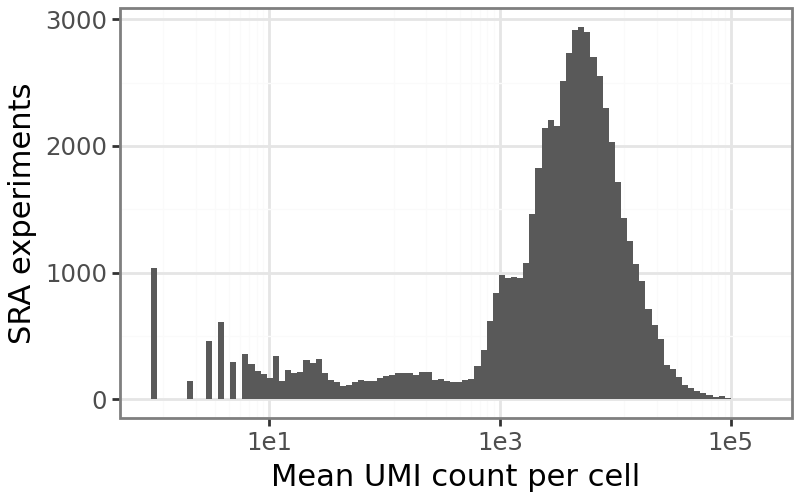

In [29]:
# plot the distribution of UMI counts
p = (
    pn.ggplot(df_cells, pn.aes(x="median_umi_per_cell")) +
    pn.geom_histogram(bins=100) +
    pn.scale_x_log10() +
    pn.labs(x="Mean UMI count per cell", y="SRA experiments") +
    pn.theme(
        figure_size=(4, 2.5),
    )
)
p